## Import Statements

In [1]:
import os
import random
import numpy as np
from numpy import where
import matplotlib.pyplot as plt

os.environ["CDF_LIB"] = "/usr/local/lib/cdf/lib/"
import netCDF4 as nc
from spacepy import pycdf
from pyspedas import wind

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from sklearn.svm import OneClassSVM

2022-06-09 10:43:34.206074: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-09 10:43:34.208687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 10:43:34.208695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Various functions

In [2]:
# Constants
e = 1.602176634e-19
m = 9.109383701528e-31
e_0 = 8.854187812813e-12
cons = e/((m*e_0)**.5)/(2*np.pi)

In [3]:
def find_closest_time(time, lst):
    return min(range(len(lst)), 
               key=lambda i: abs(time-lst[i]))

def conv_dens_to_freq(ne):
    assert ne>=0
    return ne**.5 * cons

## Building Model

In [4]:
model = Sequential()
model.add(Conv1D(8, kernel_size=2, activation='relu', input_shape=(96, 1)))
model.add(MaxPool1D(4))
model.add(Conv1D(16, kernel_size=4, activation='relu'))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 95, 8)             24        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 16)            528       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 16)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dropout (Dropout)           (None, 80)                0

2022-06-09 10:43:34.932980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 10:43:34.932995: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 10:43:34.933005: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayu): /proc/driver/nvidia/version does not exist
2022-06-09 10:43:34.933159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Importing Data

In [5]:
with nc.Dataset("data/wi_wav_tnr_19950625.nc") as file:
    time = file["tnr_ch1_time"][:]
    freq = file["tnr_ch1_freq"][:]
    spec = file["tnr_ch1_spec"][:]

In [6]:
with pycdf.CDF("data/wi_h0_wav_19950625_v01.cdf") as cdf:
    time2 = [float(x.strftime("%s")) for x in cdf["Epoch"][:]]
    density =  cdf["Ne"][:]

In [7]:
dens = []
for t in time:
    loc = find_closest_time(t, time2)
    dens.append(density[loc])

In [8]:
fpe = list(map(conv_dens_to_freq, dens))

In [9]:
print(np.shape(time), np.shape(np.transpose(spec)), np.shape(fpe))
data_v1 = [[time[i], np.transpose(spec)[i], fpe[i]] for i in range(len(fpe))]

(19419,) (19419, 96) (19419,)


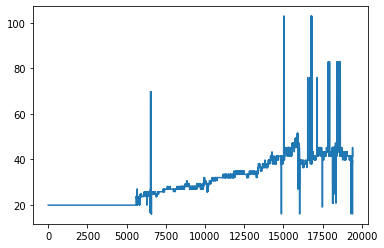

In [10]:
plt.plot(fpe)
# Noticed there were a ton of outliers and messy data, so I decided to remove them from the dataset

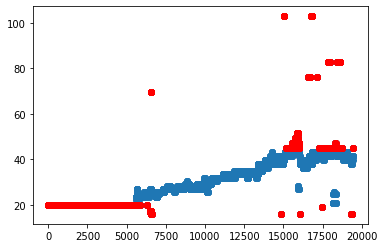

In [11]:
df = np.array(fpe).reshape(-1, 1)
svm_model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.10).fit(df)
y_pred = svm_model.predict(df)
outlier_index = where(y_pred == -1) # filter outlier values
outlier_values = df[outlier_index]
plt.scatter(list(range(len(df))), df)
plt.scatter(outlier_index, outlier_values, c = "r")

In [12]:
data_v2 = [d for d in data_v1 if d[2] > fpe[0] and d[2] < 60]
data_v2[1000:] = [d for d in data_v2[1000:] if d[2] > 30]

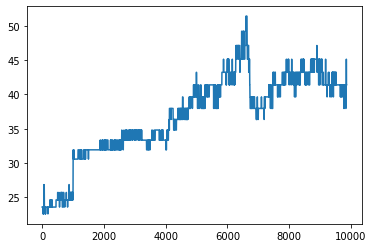

In [13]:
plt.plot([d[2] for d in data_v2])

In [14]:
random.seed(10)
random_index = list(range(len(data_v2)))
random.shuffle(random_index)
data_v3 = list(map(lambda i: data_v2[i], random_index))

In [15]:
for i in range(len(data_v3)):
    for j in range(len(data_v3)):
        if not i == j:
            if data_v3[i][0] == data_v3[j][0]:
                print(i, j)

In [16]:
x_data = np.array([d[1] for d in data_v3])
y_data = np.array([d[2] for d in data_v3])

norm_y = y_data/max(y_data)

s = len(y_data)*9//10
train_x_data, test_x_data = x_data[:s], x_data[s:]
train_y_data, test_y_data = norm_y[:s], norm_y[s:]
test_sorted = data_v3[s:]

test_sorted.sort(key=lambda x: x[0])
test_time_sorted = np.array([d[0] for d in test_sorted])
test_x_sorted = np.array([d[1] for d in test_sorted])
test_y_sorted = np.array([d[2]/max(y_data) for d in test_sorted])

## Training algorithm

In [17]:
model.compile(loss = keras.losses.mean_squared_error, 
   optimizer = keras.optimizers.Adam(), metrics = ['MeanAbsolutePercentageError'])

In [32]:
model.fit(
    x=train_x_data, y=train_y_data, epochs=200, batch_size=5, steps_per_epoch=20,
    validation_split=0.05, workers=5, use_multiprocessing=True)

Epoch 1/200
20/20 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 8.8330 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 8.3959
Epoch 2/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0040 - mean_absolute_percentage_error: 7.4181 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 7.0490
Epoch 3/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0046 - mean_absolute_percentage_error: 8.2027 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 6.5729
Epoch 4/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0049 - mean_absolute_percentage_error: 8.2177 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 6.6039
Epoch 5/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0052 - mean_absolute_percentage_error: 9.0266 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 7.2580
Epoch 6/200
20/20 [==============================] - 0s 5ms/step - loss: 0.

In [33]:
model.evaluate(test_x_data, test_y_data)

31/31 [==============================] - 0s 957us/step - loss: 0.0034 - mean_absolute_percentage_error: 6.5214


[0.0034450890962034464, 6.521376609802246]

31/31 [==============================] - 0s 788us/step


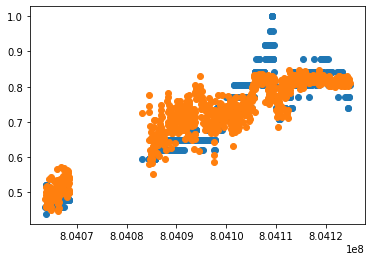

In [34]:
pred_y = model.predict(test_x_sorted)
plt.scatter(test_time_sorted, test_y_sorted)
plt.scatter(test_time_sorted, pred_y)